In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/sample_submission.csv
/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/train.csv
/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/test.csv


# **IMPORTING LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from tensorflow import keras
from keras import models, layers, optimizers, callbacks

# **READING TRAINING DATASET**

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/train.csv")

# **TRAINING DATA ANALYSIS**

In [4]:
df.shape # Check no. of rows and cols

(5647, 12)

In [5]:
df.head(5) #Check a small no. of data

,ID,Sex,Bachelor,Age,Graduated,Career,Work Experience,Family Expenses,Family Size,Variable,Segmentation,Description
0,1462220581,Male,No,41.0,Yes,Fashion Designer,2.0,Low,3,Dog_6,Akshat,The specimen is reliable and experienced.
1,1462220232,Female,Yes,38.0,Yes,HR,0.0,Average,2,Dog_6,Akshat,The specimen is reliable and experienced.
2,1462226544,Male,Yes,41.0,Yes,Fashion Designer,0.0,High,5,Dog_6,Bhavesh,The specimen is reliable and experienced.
3,1462224171,Male,No,21.0,No,Doctor,0.0,Low,4,Dog_6,Darsh,The specimen is responsible and hardworking.
4,1462226427,Female,No,37.0,Yes,Fashion Designer,0.0,Low,1,Dog_2,Bhavesh,The specimen is reliable and experienced.


In [6]:
df.info() #find the datatype of data in df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               5647 non-null   int64  
 1   Sex              5615 non-null   object 
 2   Bachelor         5523 non-null   object 
 3   Age              5626 non-null   float64
 4   Graduated        5578 non-null   object 
 5   Career           5533 non-null   object 
 6   Work Experience  5074 non-null   float64
 7   Family Expenses  5617 non-null   object 
 8   Family  Size     5399 non-null   object 
 9   Variable         5595 non-null   object 
 10  Segmentation     5647 non-null   object 
 11  Description      5647 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 529.5+ KB


In [7]:
(df.isnull().sum())/df.shape[0]*100 # looking for the share of null values in each feature

ID                  0.000000
Sex                 0.566673
Bachelor            2.195856
Age                 0.371879
Graduated           1.221888
Career              2.018771
Work Experience    10.146981
Family Expenses     0.531256
Family  Size        4.391712
Variable            0.920843
Segmentation        0.000000
Description         0.000000
dtype: float64

# **CORRELATION CHART (Training data)**

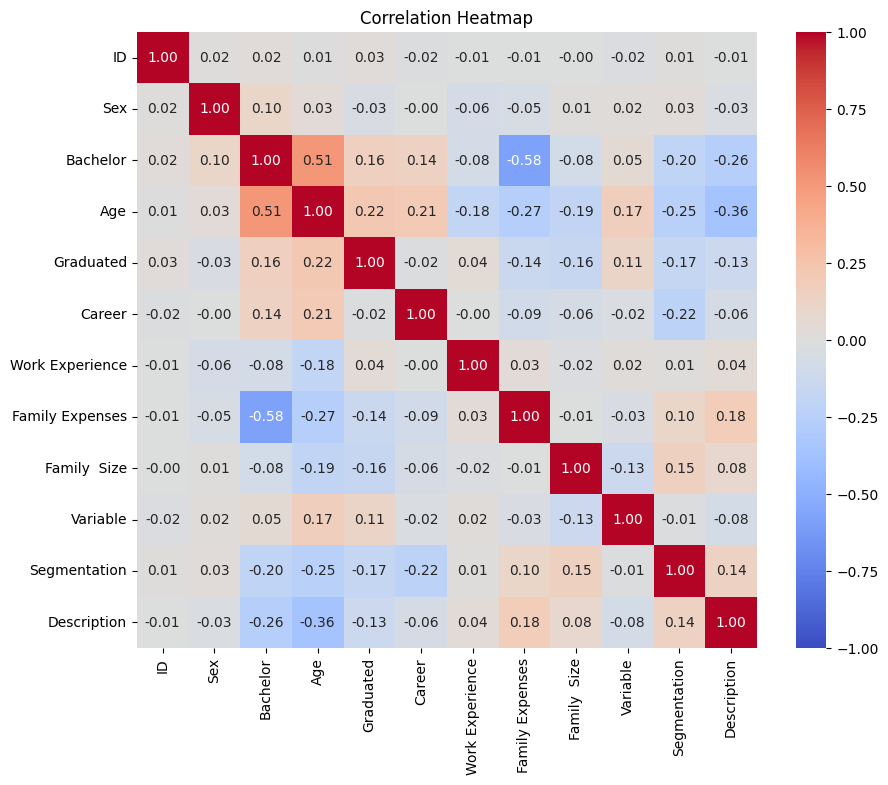

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt # importing neccesary libraries

data = pd.read_csv('/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/train.csv')

#label encoding to plot no. on the chart
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
correlation_matrix = data.corr()# correlation matrix

# plotting heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [9]:
for i in df.columns:
    print(i,df[i].unique(),'\n') # checking distinct elements of each feature to decide on mean, median,mode for fillna()
                                 

ID [1462220581 1462220232 1462226544 ... 1462220256 1462218783 1462221533] 

Sex ['Male' 'Female' nan] 

Bachelor ['No' 'Yes' nan] 

Age [41. 38. 21. 37. 89. 30. 31. 33. 32. 28. nan 47. 52. 74. 77. 35. 73. 67.
 27. 18. 42. 36. 49. 25. 58. 59. 53. 61. 65. 86. 81. 23. 26. 72. 50. 39.
 55. 51. 78. 43. 19. 85. 45. 60. 68. 46. 82. 48. 40. 20. 76. 57. 88. 71.
 87. 62. 66. 69. 22. 63. 56. 84. 29. 70. 80. 83. 75. 79.] 

Graduated ['Yes' 'No' nan] 

Career ['Fashion Designer' 'HR' 'Doctor' 'Lawyer' nan 'Scientist' 'Singer'
 'Content Creation' 'Housewife'] 

Work Experience [ 2.  0.  9.  7.  1.  6.  8. nan 11.  4.  5. 10.  3. 13. 12. 14.] 

Family Expenses ['Low' 'Average' 'High' nan] 

Family  Size ['3' '2' '5' '4' '1' '6' '9' nan '7' '8' '\\'] 

Variable ['Dog_6' 'Dog_2' 'Dog_4' nan 'Dog_7' 'Dog_3' 'Dog_1' 'Dog_5'] 

Segmentation ['Akshat' 'Bhavesh' 'Darsh' 'Chaitanya'] 

Description ['The specimen is reliable and experienced.'
 'The specimen is responsible and hardworking.'
 'The specimen is 

# **TRAIN DATA CLEANING**

**family size has some issues mainly its data type is string but its an int value also it has \\ and NaN values so to fix these issues is the below code**

In [10]:
# Fix 'Family Size' issues
df["Family  Size"] = df["Family  Size"].fillna(0)
Family_Size = {"\\": 0.5}
df["Family  Size"] = df["Family  Size"].replace(Family_Size)
df["Family  Size"] = df["Family  Size"].astype(int)

In [11]:
# filling missing values of non correlated numeric features using fillna()
df["Age"].fillna(df["Age"].mean(), inplace=True) # taking mean as normally didtributed
df["Work Experience"].fillna(df["Work Experience"].mean(), inplace=True)

/tmp/ipykernel_17/1027440538.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].mean(), inplace=True) # taking mean as normally didtributed
/tmp/ipykernel_17/1027440538.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

In [12]:
# label encoding for categorical features
le_features = {}
categorical_columns = ["Sex","Career","Bachelor","Graduated","Family Expenses","Variable","Segmentation",]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_features[col] = le

In [13]:
#filling missing data using group.by wrt to correlation chart
def fill_with_mode(series): #precaution if mode=null
    return series.dropna().mode()[0] if not series.dropna().empty else np.nan

df["Variable"].fillna(df.groupby(["Age"])["Variable"].transform(fill_with_mode),inplace=True)
df["Graduated"].fillna(df.groupby(["Age", "Variable"])["Graduated"].transform(fill_with_mode),inplace=True)
df["Bachelor"].fillna(df.groupby(["Age","Graduated"])["Bachelor"].transform(fill_with_mode),inplace=True)
df["Career"].fillna(df.groupby(["Age","Bachelor"])["Career"].transform(fill_with_mode),inplace=True)
df["Sex"].fillna(df.groupby(["Bachelor","Family  Size"])["Sex"].transform(fill_with_mode),inplace=True)
# filling family size and expeses using median bc chances of ouliers
df["Family  Size"].fillna(df.groupby(["Bachelor", "Sex"])["Family  Size"].transform('median'),inplace=True)
df["Family Expenses"].fillna(df.groupby(["Career", "Family  Size"])["Family Expenses"].transform('median'),inplace=True)

/tmp/ipykernel_17/3966642614.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Variable"].fillna(df.groupby(["Age"])["Variable"].transform(fill_with_mode),inplace=True)
/tmp/ipykernel_17/3966642614.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

In [14]:
# natural language proceesing 
# using TF-IDF for description
tfidf = TfidfVectorizer(stop_words="english")
df["Description"] = df["Description"].fillna("")
tfidf_matrix = tfidf.fit_transform(df["Description"])
X_tfidf = tfidf_matrix.toarray()


In [15]:
# standardize the data i.e standard deviation of 1 
numerical_features = ["Age", "Work Experience", "Family  Size", "Family Expenses"]
scaler = StandardScaler()
numerical_data = df[numerical_features] 
scaled_numerical_data = scaler.fit_transform(numerical_data)
df[numerical_features] = scaled_numerical_data

In [16]:
#feature engineering to increase accuracy
df['Age_WorkExp_Ratio'] = df['Age'] / (df['Work Experience'] + 1)  
df['Family_Financial_Status'] = df['Family  Size'] * df['Family Expenses']
df['Age_Career'] = df['Age'] * df['Career']

career_dummies = pd.get_dummies(df['Career'], prefix='Career')
df = pd.concat([df, career_dummies], axis=1)


In [17]:
# segregating X for features and y for target value'segmentation'
X_numerical = df.drop(columns=["Segmentation", "Description", "ID"])
y = df["Segmentation"]
X_numerical = X_numerical.astype(np.float32)

# combine numerical and text features
X = np.concatenate((X_numerical.values, X_tfidf), axis=1)

#encoding segmentation
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# **BUILDING MODEL**

In [18]:
# bulding neural network model
n_classes = len(np.unique(y_encoded))

# adding layers to the model and making it dense
model = keras.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(n_classes, activation="softmax")
])

#compiling the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

#evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

#making predictions on the basis of test set splitted from the training data 
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

f1 = f1_score(y_test, y_pred, average="weighted")# f1 score
print(f"F1 Score: {f1}")

y_pred_labels = le_target.inverse_transform(y_pred)
print(y_pred)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2731 - loss: 1.7664 - val_accuracy: 0.3009 - val_loss: 1.3746
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3460 - loss: 1.4369 - val_accuracy: 0.3717 - val_loss: 1.2814
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3773 - loss: 1.3502 - val_accuracy: 0.4735 - val_loss: 1.1725
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4376 - loss: 1.2837 - val_accuracy: 0.4823 - val_loss: 1.1589
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4307 - loss: 1.2440 - val_accuracy: 0.4823 - val_loss: 1.1515
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4409 - loss: 1.2279 - val_accuracy: 0.4801 - val_loss: 1.1308
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4417 - loss: 1.2166 - val_accuracy: 0.5000 - val_loss: 1.1208
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4541 - loss: 1.1877 - val_accu

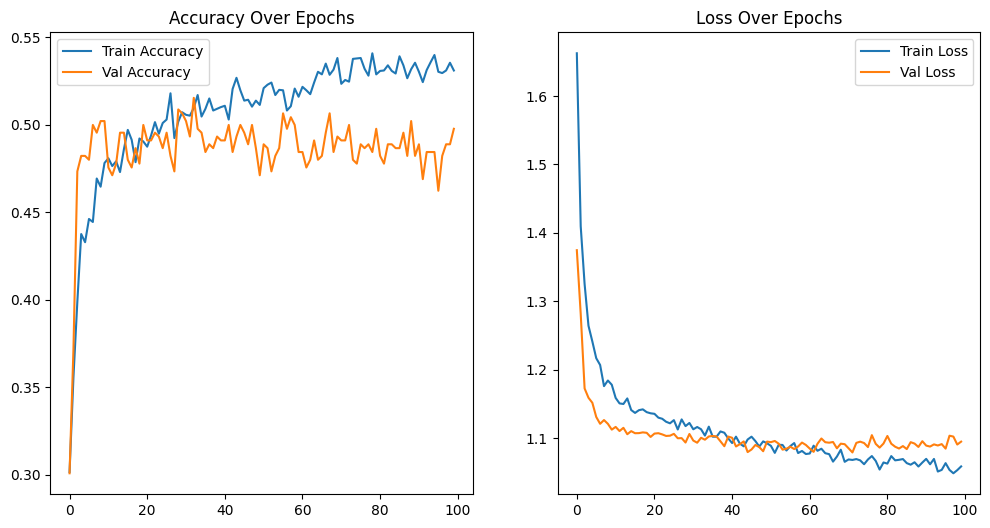

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

# **CORRELATION CHART(Test Data)**

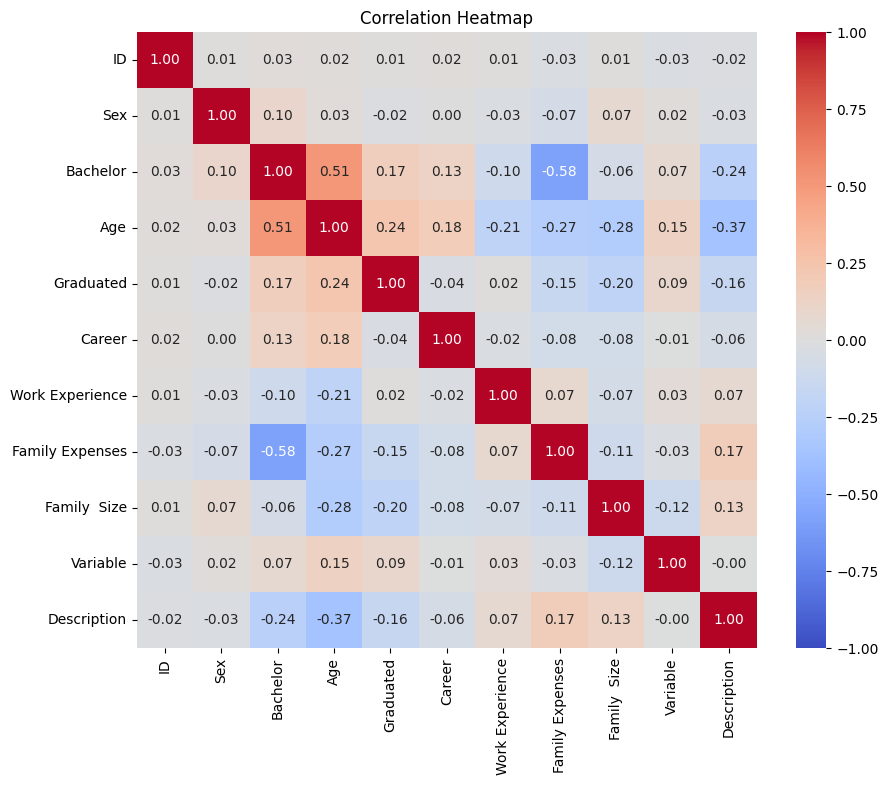

In [20]:
test_data = pd.read_csv('/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/test.csv')
categorical_cols = test_data.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    test_data[col] = le.fit_transform(test_data[col])
    label_encoders[col] = le
correlation_matrix = test_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# **TEST DATA CLEANING**

In [21]:
# same as train data cleaning
test_df = pd.read_csv('/kaggle/input/praxis-24-ml-hackathon-hosted-by-gdgc-dseu/test.csv')

tfidf = TfidfVectorizer(stop_words="english")
test_df["Description"] = test_df["Description"].fillna("")
tfidf_matrix = tfidf.fit_transform(test_df["Description"]) 
X_tfidf = tfidf_matrix.toarray()

test_df["Age"].fillna(test_df["Age"].mean(), inplace=True)
test_df["Work Experience"].fillna(test_df["Work Experience"].mean(), inplace=True)

test_df["Family  Size"] = test_df["Family  Size"].fillna(0)
Family_Size = {"\\": 0.5}
test_df["Family  Size"] = test_df["Family  Size"].replace(Family_Size)
test_df["Family  Size"] = test_df["Family  Size"].astype(int)

le_features = {} 
categorical_columns = ["Sex","Career","Bachelor","Graduated","Family Expenses","Variable"]
for col in categorical_columns:
    le = LabelEncoder() 
    test_df[col] = le.fit_transform(test_df[col]) 

def fill_with_mode(series):
    return series.dropna().mode()[0] if not series.dropna().empty else np.nan

test_df["Variable"].fillna(test_df.groupby(["Age"])["Variable"].transform(fill_with_mode), inplace=True)
test_df["Graduated"].fillna(test_df.groupby(["Age", "Variable"])["Graduated"].transform(fill_with_mode), inplace=True)
test_df["Bachelor"].fillna(test_df.groupby(["Age","Graduated"])["Bachelor"].transform(fill_with_mode), inplace=True)
test_df["Career"].fillna(test_df.groupby(["Age","Bachelor"])["Career"].transform(fill_with_mode), inplace=True)
test_df["Sex"].fillna(test_df.groupby(["Bachelor","Family  Size"])["Sex"].transform(fill_with_mode), inplace=True)
test_df["Family  Size"].fillna(test_df.groupby(["Bachelor", "Sex"])["Family  Size"].transform('median'),inplace=True)
test_df["Family Expenses"].fillna(test_df.groupby(["Career", "Family  Size"])["Family Expenses"].transform('median'),inplace=True)

numerical_features = ["Age", "Work Experience", "Family  Size", "Family Expenses"]
scaler = StandardScaler()
numerical_data = test_df[numerical_features]  
scaled_numerical_data = scaler.fit_transform(numerical_data)
test_df[numerical_features] = scaled_numerical_data


test_df['Age_WorkExp_Ratio'] = test_df['Age'] / (test_df['Work Experience'] + 1)  

test_df['Family_Financial_Status'] = test_df['Family  Size'] * test_df['Family Expenses']

test_df['Age_Career'] = test_df['Age'] * test_df['Career']

career_dummies = pd.get_dummies(test_df['Career'], prefix='Career')
test_df = pd.concat([test_df, career_dummies], axis=1)


X_numerical = test_df.drop(columns=["Description", "ID"])  
X_numerical = X_numerical.astype(np.float32)
X = np.concatenate((X_numerical.values, X_tfidf), axis=1)


/tmp/ipykernel_17/207563692.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df["Age"].fillna(test_df["Age"].mean(), inplace=True)
/tmp/ipykernel_17/207563692.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

# **PREDICTION**

In [22]:
# making predictions using the loaded model
y_pred_probs = model.predict(X)
y_pred = np.argmax(y_pred_probs, axis=1)

#reverse the label encoding to get original labels
le_target = LabelEncoder() 
le_target.fit(df["Segmentation"])
y_pred_labels = le_target.inverse_transform(y_pred)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [23]:
y_pred_classes = y_pred
# reshapeing y_pred_classes to have a single column to match the shape of y_test
y_pred_reshaped = y_pred_classes.reshape(-1,)
print(y_pred_reshaped.shape)
y_pred_reshaped

(2421,)


array([0, 1, 3, ..., 0, 1, 0])

In [24]:
import pandas as pd
chart=test_df['ID']
num_predictions = len(y_pred)
chart_subset = chart[:num_predictions]

y_pred_classes = y_pred

df_results = pd.DataFrame({'ID': chart_subset, 'Segmentation': y_pred_reshaped})

#writing the dataFrame to a CSV file
df_results.to_csv('final_predictions.csv', index=False)

res = pd.read_csv('final_predictions.csv')
res.shape
res = pd.read_csv('final_predictions.csv')

#defining a function to map numeric values to strings
def map_segmentation(value):
    if value == 0:
        return 'Akshat'
    elif value == 1:
        return 'Bhavesh'
    elif value == 3:
        return 'Darsh'
    else:
        return 'Chaitanya'

res['Segmentation'] = res['Segmentation'].apply(map_segmentation)
res.to_csv('final_predictions.csv', index=False)